# LSTM Model: 1 Timestep

## Packages

In [2]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

import matplotlib.pyplot as plt
from math import sqrt

## Prep Data for LSTM

In [3]:
pirates = pd.read_csv('data/pirates.csv')

In [4]:
pirates.head(2)

,datetime,wait_time,WDWMAXTEMP,WDWMINTEMP,WDWMEANTEMP,inSession,MKHOURSEMH,WEATHER_WDWPRECIP,MKPRDDAY,MKPRDNGT,...,MONTH_Nov,MONTH_Oct,MONTH_Sep,DAY_Friday,DAY_Monday,DAY_Saturday,DAY_Sunday,DAY_Thursday,DAY_Tuesday,DAY_Wednesday
0,2016-01-01 08:07:00,5.0,82.73,67.78,75.26,0.0,18.0,0.12,2,1,...,0,0,0,1,0,0,0,0,0,0
1,2016-01-01 08:14:00,5.0,82.73,67.78,75.26,0.0,18.0,0.12,2,1,...,0,0,0,1,0,0,0,0,0,0


In [5]:
pirates['datetime'] = pd.to_datetime(pirates['datetime'])

### Split into Train/Test/Validate

train - year 2016-2017

test - year 2018

validate - year 2019

In [6]:
train = pirates.loc[(pirates['datetime'].dt.year >= 2016) & (pirates['datetime'].dt.year <= 2017)]
test = pirates[(pirates['datetime'].dt.year==2018)]
val = pirates[(pirates['datetime'].dt.year==2019)]

In [7]:
print(train.shape)
print(test.shape)
print(val.shape)

(91006, 53)
(53990, 53)
(49233, 53)


In [8]:
#set datetime as the index
train = train.set_index('datetime')
test = test.set_index('datetime')
val = val.set_index('datetime')

In [9]:
train.head()

,wait_time,WDWMAXTEMP,WDWMINTEMP,WDWMEANTEMP,inSession,MKHOURSEMH,WEATHER_WDWPRECIP,MKPRDDAY,MKPRDNGT,SUNSET_HOUR_17,...,MONTH_Nov,MONTH_Oct,MONTH_Sep,DAY_Friday,DAY_Monday,DAY_Saturday,DAY_Sunday,DAY_Thursday,DAY_Tuesday,DAY_Wednesday
datetime,,,,,,,,,,,,,,,,,,,,,
2016-01-01 08:07:00,5.0,82.73,67.78,75.26,0.0,18.0,0.12,2,1,1,...,0,0,0,1,0,0,0,0,0,0
2016-01-01 08:14:00,5.0,82.73,67.78,75.26,0.0,18.0,0.12,2,1,1,...,0,0,0,1,0,0,0,0,0,0
2016-01-01 08:21:00,5.0,82.73,67.78,75.26,0.0,18.0,0.12,2,1,1,...,0,0,0,1,0,0,0,0,0,0
2016-01-01 08:27:00,5.0,82.73,67.78,75.26,0.0,18.0,0.12,2,1,1,...,0,0,0,1,0,0,0,0,0,0
2016-01-01 08:29:00,5.0,82.73,67.78,75.26,0.0,18.0,0.12,2,1,1,...,0,0,0,1,0,0,0,0,0,0


### Scale the Data

In [10]:
scaler = MinMaxScaler(feature_range=(0, 1))

In [11]:
def scale_data(data):
    """Function to transform df into scaled data. Returns a numpy array."""
    
    # create array of values
    values = data.values
    # normalize features
    values = values.astype('float32')
    
    scaled = scaler.fit_transform(values)
    return scaled

In [12]:
train_scaled = scale_data(train)
test_scaled = scale_data(test)
val_scaled = scale_data(val)

In [13]:
train_scaled

array([[0.04      , 0.694064  , 0.72962403, ..., 0.        , 0.        ,
        0.        ],
       [0.04      , 0.694064  , 0.72962403, ..., 0.        , 0.        ,
        0.        ],
       [0.04      , 0.694064  , 0.72962403, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.08000001, 0.38698626, 0.22755927, ..., 0.        , 0.        ,
        0.        ],
       [0.08000001, 0.38698626, 0.22755927, ..., 0.        , 0.        ,
        0.        ],
       [0.08000001, 0.38698626, 0.22755927, ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

### Convert Time Series to Samples

Reframe the time series as a supervised learning. Takes one past timestep to predict the next timestep.

In [14]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [15]:
n_steps_past = 1
n_steps_future = 1
n_features = 52

# reframe for supervise
train_reframe = series_to_supervised(train_scaled, n_steps_past, n_steps_future)
test_reframe = series_to_supervised(test_scaled, n_steps_past, n_steps_future)
val_reframe = series_to_supervised(val_scaled, n_steps_past, n_steps_future)

In [16]:
train_reframe.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),...,var43(t),var44(t),var45(t),var46(t),var47(t),var48(t),var49(t),var50(t),var51(t),var52(t)
1,0.04,0.694064,0.729624,0.720009,0.0,1.0,0.28125,0.666667,0.5,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.04,0.694064,0.729624,0.720009,0.0,1.0,0.28125,0.666667,0.5,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.04,0.694064,0.729624,0.720009,0.0,1.0,0.28125,0.666667,0.5,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.04,0.694064,0.729624,0.720009,0.0,1.0,0.28125,0.666667,0.5,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.04,0.694064,0.729624,0.720009,0.0,1.0,0.28125,0.666667,0.5,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
# select all t-i and the t columns
train_reframe = train_reframe.iloc[:, :53]
test_reframe = test_reframe.iloc[:, :53]
val_reframe = val_reframe.iloc[:, :53]

train_reframe.head(2)

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),...,var44(t-1),var45(t-1),var46(t-1),var47(t-1),var48(t-1),var49(t-1),var50(t-1),var51(t-1),var52(t-1),var1(t)
1,0.04,0.694064,0.729624,0.720009,0.0,1.0,0.28125,0.666667,0.5,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.04
2,0.04,0.694064,0.729624,0.720009,0.0,1.0,0.28125,0.666667,0.5,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.04


### Split into input/output and reshape

Split the train, test, and val into features and labels.

In [ ]:
n_obs_past = n_steps_past * n_features
n_obs_future = n_steps_future * n_features

In [22]:
train_X, train_y = train_reframe.iloc[:, :-1], train_reframe.iloc[:, -1]
test_X, test_y = test_reframe.iloc[:, :-1], test_reframe.iloc[:, -1]
val_X, val_y = val_reframe.iloc[:, :-1], val_reframe.iloc[:, -1]

In [23]:
train_y

1        0.04
2        0.04
3        0.04
4        0.04
5        0.00
         ... 
91001    0.08
91002    0.08
91003    0.08
91004    0.08
91005    0.08
Name: var1(t), Length: 90276, dtype: float32

In [24]:
# get values in array

train_X, train_y = train_X.values, train_y.values
test_X, test_y = test_X.values, test_y.values
val_X, val_y = val_X.values, val_y.values

In [25]:
train_y

array([0.04      , 0.04      , 0.04      , ..., 0.08000001, 0.08000001,
       0.08000001], dtype=float32)

In [26]:
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape, val_X.shape, val_y.shape)

(90276, 52) (90276,) (53989, 52) (53989,) (49126, 52) (49126,)


Reshape features vector into 3D.

In [27]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_steps_past, n_features))
test_X = test_X.reshape((test_X.shape[0], n_steps_past, n_features))
val_X = val_X.reshape((val_X.shape[0], n_steps_past, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape, val_X.shape, val_y.shape)

(90276, 1, 52) (90276,) (53989, 1, 52) (53989,) (49126, 1, 52) (49126,)


In [28]:
train_X

array([[[0.04      , 0.694064  , 0.72962403, ..., 0.        ,
         0.        , 0.        ]],

       [[0.04      , 0.694064  , 0.72962403, ..., 0.        ,
         0.        , 0.        ]],

       [[0.04      , 0.694064  , 0.72962403, ..., 0.        ,
         0.        , 0.        ]],

       ...,

       [[0.08000001, 0.38698626, 0.22755927, ..., 0.        ,
         0.        , 0.        ]],

       [[0.08000001, 0.38698626, 0.22755927, ..., 0.        ,
         0.        , 0.        ]],

       [[0.08000001, 0.38698626, 0.22755927, ..., 0.        ,
         0.        , 0.        ]]], dtype=float32)

## LSTM Model

### Model 1: LSTM: 50, Epochs:100, Batch Size: 72

#### Create & fit the model

In [29]:
# create the model
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                20600     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 20,651
Trainable params: 20,651
Non-trainable params: 0
_________________________________________________________________


In [30]:
# fit the model
history = model.fit(train_X, train_y, epochs=100, batch_size=72, 
                    validation_data=(test_X, test_y), verbose=2, shuffle=False)


Train on 90276 samples, validate on 53989 samples
Epoch 1/100
 - 2s - loss: 0.0644 - val_loss: 0.0743
Epoch 2/100
 - 2s - loss: 0.0462 - val_loss: 0.0674
Epoch 3/100
 - 2s - loss: 0.0424 - val_loss: 0.0607
Epoch 4/100
 - 2s - loss: 0.0419 - val_loss: 0.0515
Epoch 5/100
 - 2s - loss: 0.0389 - val_loss: 0.0600
Epoch 6/100
 - 2s - loss: 0.0400 - val_loss: 0.0538
Epoch 7/100
 - 2s - loss: 0.0380 - val_loss: 0.0527
Epoch 8/100
 - 2s - loss: 0.0382 - val_loss: 0.0515
Epoch 9/100
 - 2s - loss: 0.0364 - val_loss: 0.0469
Epoch 10/100
 - 2s - loss: 0.0368 - val_loss: 0.0522
Epoch 11/100
 - 2s - loss: 0.0365 - val_loss: 0.0452
Epoch 12/100
 - 2s - loss: 0.0362 - val_loss: 0.0414
Epoch 13/100
 - 2s - loss: 0.0356 - val_loss: 0.0445
Epoch 14/100
 - 2s - loss: 0.0355 - val_loss: 0.0435
Epoch 15/100
 - 2s - loss: 0.0359 - val_loss: 0.0429
Epoch 16/100
 - 2s - loss: 0.0352 - val_loss: 0.0442
Epoch 17/100
 - 2s - loss: 0.0351 - val_loss: 0.0445
Epoch 18/100
 - 2s - loss: 0.0356 - val_loss: 0.0424
Epoc

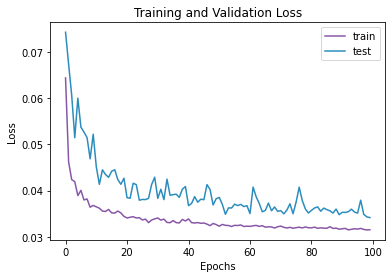

In [51]:
#Plot the loss 

plt.plot(history.history['loss'], label='train', color= '#8856a7')
plt.plot(history.history['val_loss'], label='test', color='#2b8cbe')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.savefig('graphs/train_val_loss.svg', format='svg', dpi=300, bbox_inches='tight')

plt.show()

In [40]:
# save history to file
hist_df = pd.DataFrame(history.history) 

hist_csv_file = 'results/loss_history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

#### Predict on Test Data

In [41]:
# predict on test
yhat = model.predict(test_X)
model_test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# invert scaling for forecast
inv_yhat = np.concatenate((yhat, model_test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
model_test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((model_test_y, model_test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

# calculate MAE
mae = mean_absolute_error(inv_y, inv_yhat)
print('Test MAE: %.3f' % mae)

Test RMSE: 10.391
Test MAE: 6.146


In [42]:
# save test predictions to file
yhat_df = pd.DataFrame(inv_yhat)

yhat_csv_file = 'results/test_predictions.csv'
with open (yhat_csv_file, mode='w') as f:
    yhat_df.to_csv(f)

In [43]:
# save test actual to file
y_df = pd.DataFrame(inv_y)

y_csv_file = 'results/test_actual.csv'
with open (y_csv_file, mode='w') as f:
    y_df.to_csv(f)

### Model 2: LSTM(100), Epochs:100 Batch Size: 72

#### Create & fit the model

In [35]:
# create the model
model2 = Sequential()
model2.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model2.add(Dense(1))
model2.compile(loss='mae', optimizer='adam')
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 100)               61200     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 61,301
Trainable params: 61,301
Non-trainable params: 0
_________________________________________________________________


In [36]:
# fit the model
history2 = model2.fit(train_X, train_y, epochs=100, batch_size=72, 
                    validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 90276 samples, validate on 53989 samples
Epoch 1/100
 - 2s - loss: 0.0606 - val_loss: 0.1536
Epoch 2/100
 - 2s - loss: 0.0483 - val_loss: 0.0816
Epoch 3/100
 - 2s - loss: 0.0441 - val_loss: 0.0970
Epoch 4/100
 - 2s - loss: 0.0417 - val_loss: 0.0602
Epoch 5/100
 - 2s - loss: 0.0400 - val_loss: 0.0457
Epoch 6/100
 - 2s - loss: 0.0378 - val_loss: 0.0453
Epoch 7/100
 - 2s - loss: 0.0372 - val_loss: 0.0481
Epoch 8/100
 - 2s - loss: 0.0371 - val_loss: 0.0446
Epoch 9/100
 - 2s - loss: 0.0363 - val_loss: 0.0440
Epoch 10/100
 - 2s - loss: 0.0367 - val_loss: 0.0465
Epoch 11/100
 - 2s - loss: 0.0366 - val_loss: 0.0575
Epoch 12/100
 - 2s - loss: 0.0360 - val_loss: 0.0423
Epoch 13/100
 - 2s - loss: 0.0359 - val_loss: 0.0475
Epoch 14/100
 - 2s - loss: 0.0357 - val_loss: 0.0398
Epoch 15/100
 - 2s - loss: 0.0348 - val_loss: 0.0424
Epoch 16/100
 - 2s - loss: 0.0347 - val_loss: 0.0415
Epoch 17/100
 - 2s - loss: 0.0344 - val_loss: 0.0423
Epoch 18/100
 - 2s - loss: 0.0347 - val_loss: 0.0411
Epoch

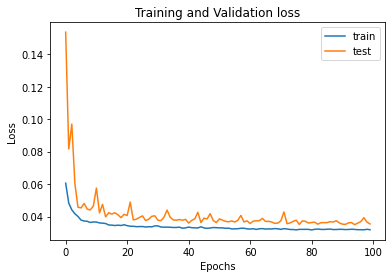

In [37]:
#Plot the loss 

plt.plot(history2.history['loss'], label='train')
plt.plot(history2.history['val_loss'], label='test')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

#### Predict on Test data

In [38]:
# predict on test
yhat = model2.predict(test_X)
model2_test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# invert scaling for forecast
inv_yhat = np.concatenate((yhat, model2_test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
model2_test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((model2_test_y, model2_test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

# calculate MAE
mae = mean_absolute_error(inv_y, inv_yhat)
print('Test MAE: %.3f' % mae)

Test RMSE: 10.567
Test MAE: 6.371


### Validate Model on Validation Data

The model chosen, the fisrt model, will be validated on the validation dataset.

In [45]:
# predict on validation 
yhat_val = model.predict(val_X)
model_val_X = val_X.reshape((val_X.shape[0], test_X.shape[2]))

# invert scaling for forecast
inv_yhat_val = np.concatenate((yhat_val, model_val_X[:, 1:]), axis=1)
inv_yhat_val = scaler.inverse_transform(inv_yhat_val)
inv_yhat_val = inv_yhat_val[:,0]

# invert scaling for actual
model_val_y = val_y.reshape((len(val_y), 1))
inv_y_val = np.concatenate((model_val_y, model_val_X[:, 1:]), axis=1)
inv_y_val = scaler.inverse_transform(inv_y_val)
inv_y_val = inv_y_val[:,0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y_val, inv_yhat_val))
print('Test RMSE: %.3f' % rmse)

# calculate MAE
mae = mean_absolute_error(inv_y_val, inv_yhat_val)
print('Test MAE: %.3f' % mae)

Test RMSE: 7.174
Test MAE: 4.423


In [46]:
# save validation predictions to file
val_yhat_df = pd.DataFrame(inv_yhat_val)

val_yhat_csv_file = 'results/val_predictions.csv'
with open (val_yhat_csv_file, mode='w') as f:
    val_yhat_df.to_csv(f)

In [48]:
# save validation actual to file
val_y_df = pd.DataFrame(inv_y_val)

val_y_csv_file = 'results/val_actual.csv'
with open (val_y_csv_file, mode='w') as f:
    val_y_df.to_csv(f)

#### Resource:
Brownlee, Jason. (2017). Multivariate Time Series Forecasting with LSTMs in Keras. Retrieved from https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/